#Setup

In [ ]:
import csv
import math
import numpy as np
import pandas as pd
from scipy import stats 
from matplotlib import cm
import plotly.express as px
import matplotlib.pyplot as plt 
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy.interpolate import interp2d
from matplotlib.animation import FuncAnimation
from scipy.signal import find_peaks, savgol_filter


np.set_printoptions(suppress=True)

In [ ]:
def format_points(point_array):
  grouped = []

  for i in range(int((point_array.size - 5) / 3)): 
    index = (i * 3) + 5
    point_set = np.array([point_array[0,index], point_array[0,index + 1], point_array[0,index + 2]])
    grouped.append(point_set)


  return np.array(grouped).reshape(7,7,3)

In [ ]:
def closest_value(input_arr, input_value):
  input_value -= 97.6
  i = (np.abs(input_arr - input_value)).argmin()
 
  return input_arr[i]

In [ ]:
def get_point_mat(path, control_col = 3, header_rows = 2, indent_value = 20):
  """
  Converts csv inread values to a 3D point matrix with shape 8,8,3 in order to correctly assign marker coordinates 
  :param control_col: control column with reference point, location of control marker in csv
  :param header_rows: amount of info header in sheet
  :param indent_value:  finds closest value to desired indent
  """
  marker_data = np.genfromtxt(path, delimiter=',', skip_header = header_rows)
  transposed_md = marker_data.T 

  control_min = np.amin(transposed_md[control_col])
  control_max = np.amax(transposed_md[control_col])


  indent = closest_value(transposed_md[control_col], indent_value)

  cmin_result = np.where(marker_data == control_min)
  cmax_result = np.where(marker_data == indent)

  origin = marker_data[cmin_result[0]]
  touch = marker_data[cmax_result[0]]

  origin_point_mat = format_points(origin)
  touch_point_mat = format_points(touch)

  return origin_point_mat, touch_point_mat

In [ ]:
def calculate_delta(origin_point_mat, touch_point_mat, orientations = "tblr"):
  point_number = 7
  delta_e = []
  delta = []

  for char in orientations:
    char_delta_e, char_delta = [], []

    if char == "t" or char == "l":
      y = 0
    elif char == "b" or char == "r":
      y = point_number - 2

    for x in range(point_number):
      if char == "t" or char == "b":
        ao, at = origin_point_mat[x,y], touch_point_mat[x,y]
        bo, bt = origin_point_mat[x,y+1], touch_point_mat[x,y+1]
      else:
        ao, at = origin_point_mat[y,x], touch_point_mat[y,x]
        bo, bt = origin_point_mat[y+1,x], touch_point_mat[y+1,x]          


      #euclidian 3d
      dist_oe = np.linalg.norm(ao-bo)
      dist_te = np.linalg.norm(at-bt)

      #distance 2d
      dist_o = math.sqrt((bo[0] - ao[0])**2 + (bo[2] - ao[2])**2)
      dist_t = math.sqrt((bt[0] - at[0])**2 + (bt[2] - at[2])**2)

      char_delta.append(abs(dist_o - dist_t))
      char_delta_e.append(abs(dist_oe - dist_te))

    delta.append(np.asarray(char_delta))
    delta_e.append(np.asarray(char_delta_e))

  delta = np.asarray(delta)
  delta_e = np.asarray(delta_e)

  return delta, delta_e, orientations

In [ ]:
def snr(path, start, stop):
  data = np.genfromtxt(path, delimiter=',', skip_header = 2)
  std_dev = 0
  for i in range(2, data.shape[1]):
    area = data[start:stop, i]
    n = len(area)
    mean = sum(area) / n
    var =  sum((x - mean) ** 2 for x in area) / (n - 0)

    std_dev += math.sqrt(var)

  print(std_dev/data.shape[1])

  

#Singular Input - Analysis 8x8

In [ ]:
snr('/content/drive/MyDrive/mil/data/fixed_points/take_20220720_1x2y.csv', 0, 100)


0.006395507228136905


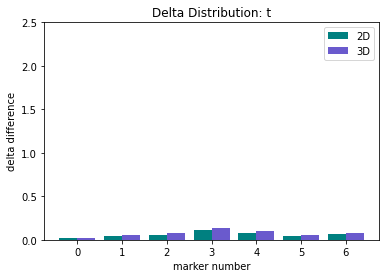

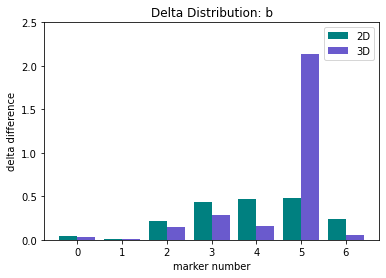

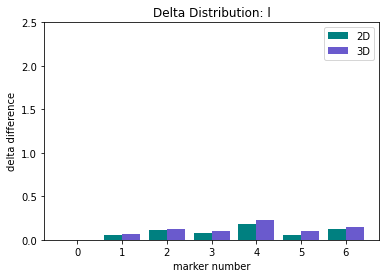

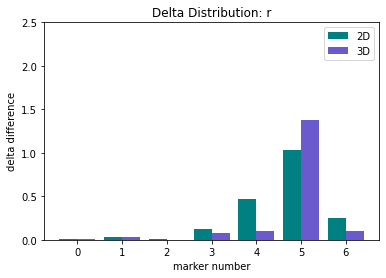

In [ ]:
#path = '//content/drive/MyDrive/mil/data/fixed_points/take_20220720_1x2y.csv'
#path = '//content/drive/MyDrive/mil/data/fixed_points/take_20220720_3x3y.csv'
path = '/content/drive/MyDrive/mil/data/fixed_points/take_20220720_5x5y.csv'

indent_value = 20 #find closest value in mm


origin_point_mat, touch_point_mat = get_point_mat(path, indent_value = indent_value)




deltas, deltas_e, orientations = calculate_delta(origin_point_mat, touch_point_mat)

for i in range(min(deltas.shape[0],deltas_e.shape[0], len(orientations))):
  delta = deltas[i]
  delta_e = deltas_e[i]
  orientation = orientations[i]

  
  plt_x =  np.arange(delta.size)
  plt.bar(plt_x - 0.2, delta, width = 0.4, label = "2D", color = "teal") 
  plt.bar(plt_x + 0.2, delta_e, width = 0.4, label = "3D", color = "slateblue") 
  #plt.gca().invert_yaxis()
  plt.xlabel('marker number') 
  plt.ylabel('delta difference')
  plt.title('Delta Distribution: ' + orientation) 
  plt.legend(loc = 'best')
  plt.ylim(top = 2.5)
    
  plt.show() 
  



#Multiple Input



##Panda


In [ ]:
path = '/content/drive/MyDrive/mil/data/take_202207261713.csv'
dataframe = pd.read_csv(path, delimiter=';', index_col=False)


FileNotFoundError: ignored

#Analysis

###Peaks

In [ ]:
path = '/content/drive/MyDrive/mil/data/formatted/f_take_202208031230.csv'

marker_data = np.genfromtxt(path, delimiter=',', skip_header=1)
transposed_md = marker_data.T

In [ ]:
i = 3
control_min = np.amin(transposed_md[i])
control_max = np.amax(transposed_md[i])

print(control_max, control_min)

max_diff = abs(control_max-control_min)

print(max_diff)

-75.491928 -121.534653
46.042725000000004


In [ ]:
md = marker_data.copy()
#order values correctly
for i in range(2,md.shape[1]-2,3):
  md[:, [i+1,i]] = md[:,[i,i+1]]
  md[:, [i+2,i+1]] = md[:,[i+1,i+2]]

print(md[0])


[   0.          0.        -82.587532  -28.59564  -142.513763   -6.055618
  111.422829    0.107238   -4.840031   92.301208    0.246018   -3.282042
   74.576027    0.427595   -1.619561   55.778969    0.50718     0.508638
   36.38789     0.558716    2.940361   18.953045    0.27244     3.478178
   -0.538953   -0.781981   -5.903006  111.361435   17.503588   -4.125251
   92.639992   18.434586   -2.434145   74.668205   17.951654   -0.192492
   55.591347   17.218134    2.784159   36.34285    17.405922    7.805742
   18.07295    16.860207   10.739987   -0.928829   14.97366    -5.777848
  111.927284   35.836491   -3.946442   93.121788   36.556328   -2.020382
   75.075912   36.915722    0.431141   56.421494   36.233662    3.878251
   36.355572   35.801128    9.18216    16.731821   35.804462   11.916801
   -0.534399   34.911152   -5.602056  112.194298   54.241261   -3.752288
   93.032066   55.199631   -1.857306   74.821815   55.527393    0.449486
   55.977306   55.187004    3.399021   36.762825   

In [ ]:
print(md.shape)

(360271, 152)


(1207,)


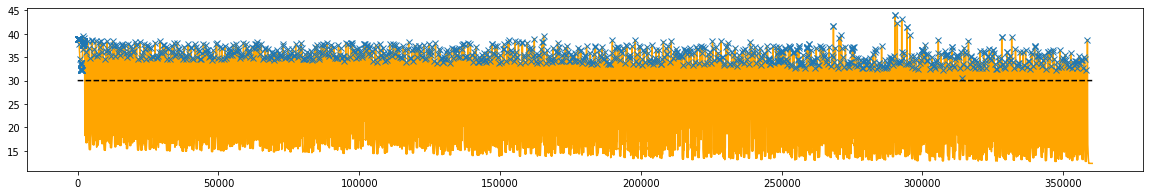

In [ ]:
x = md[:,2]+ abs(control_min)
#snr(path, 0, 29000)


y = savgol_filter(x, 71, 0) #+105.959152


peaks, _ = find_peaks(y, height=30)
print(peaks.shape)
plt.figure( figsize = (20,3))
#plt.plot(x)
plt.plot(y, color = 'orange')
plt.plot(peaks, y[peaks], "x")
plt.plot(np.zeros_like(y)+30, "--", color="black")
plt.show()

In [ ]:
delta_peaks = []

for i in range(peaks.size-1):
  d = peaks[i+1] - peaks[i]
  delta_peaks.append(d)


delta_peaks = np.array(delta_peaks)

loc = np.where(delta_peaks > 212)

dp_x = delta_peaks[loc]


#print('Location of peaks:', peaks[loc])
print('Amount of peaks:', peaks[loc].size)
print('Median:', np.median(md[peaks[loc], 2]- control_min))
print('Mean:', np.mean(md[peaks[loc], 2]- control_min))
print('Standarddeviation:', np.std(md[peaks[loc], 2]- control_min))
print('Variance:', np.var(md[peaks[loc], 2]- control_min))



Amount of peaks: 997
Median: 35.52762600000001
Mean: 35.64090291273822
Standarddeviation: 1.6621572497523647
Variance: 2.7627667229043444


###Cross Section first Row

In [ ]:
print('Location of peaks:\n', peaks[loc])
np.save('/content/drive/MyDrive/mil/data/analytics/peaks.npy', peaks[loc])


Location of peaks:
 [   463   1382   2413   2719   3102   3542   3908   4345   4919   5166
   5645   5964   6349   6890   7150   7588   7906   8255   8709   9104
   9649  10048  10462  10846  11106  11426  11838  12379  12665  12922
  13336  13728  13959  14318  14600  14847  15183  15606  15835  16109
  16436  16811  17209  17518  18022  18381  18667  19056  19331  19620
  19869  20260  20589  20896  21448  22032  22615  22919  23192  23515
  23769  24196  24719  24965  25239  25658  26077  26464  26696  26922
  27450  28017  28270  28515  28828  29265  29710  29946  30333  30613
  30927  31261  31748  32219  32700  33071  33421  33768  34194  34695
  34957  35423  35777  36003  36336  36601  36915  37306  37778  38169
  38467  38758  39252  39698  40080  40315  40756  40999  41564  41854
  42310  42714  42981  43214  43603  43838  44182  44635  45049  45406
  45804  46098  46319  46691  46919  47154  47390  47719  48159  48543
  49039  49325  49901  50365  50851  51315  51784  52289 

Indent measured:


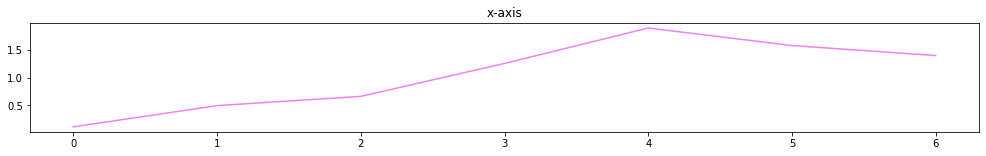

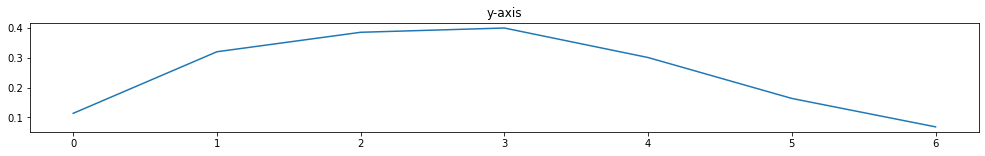

In [ ]:
value_at = 463
zero_avg_x_x = np.average(np.array(md[:500,5:24:3]), axis=0) #x along x
zero_avg_x_y = np.average(np.array(md[:500,5::21]), axis=0)  #x along y


csx = abs(np.subtract(md[value_at,5:24:3], zero_avg_x_x))
csy = abs(np.subtract(md[value_at,5::21], zero_avg_x_y))

#print(np.amax(abs(np.subtract(md[:,5:23:3], md[0,5:23:3]))))

print('Indent measured:')
plt.figure(figsize=(17,2))
#plt.ylim(0,2)
plt.plot(csx, color = 'violet')
plt.title('x-axis')
plt.show()

plt.figure(figsize=(17,2))
#plt.ylim(0,2)
plt.plot(csy)
plt.title('y-axis')
plt.show()

###Cross sections

Indent measured:
[0.11373907 0.49644565 0.66366056 1.25753293 1.89615121 1.58023808
 1.39961885]
[0.47874707 1.46303765 2.12992856 3.87667893 7.54361721 9.84807008
 2.12299115]
[0.68071007 1.79061465 2.93763556 4.90815593 8.95232821 8.01206208
 2.44867715]
[0.88104307 2.08999465 2.94618356 4.38730593 5.68050621 4.60050808
 1.45879215]
[0.81198707 1.68073665 2.25308856 2.93581893 2.75675621 1.28612908
 0.04475315]
[0.63466907 1.19820265 1.29194656 1.26042293 0.70109621 0.98402692
 1.35456185]
[0.49597207 0.70190065 0.27229156 0.13053407 1.33991879 2.97730292
 2.77971985]


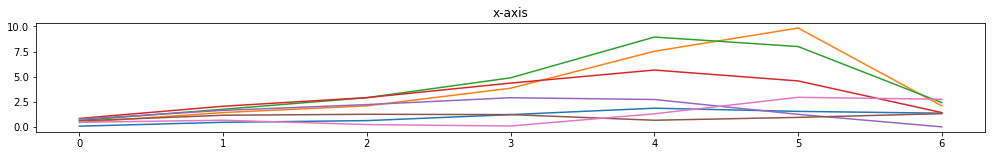

In [ ]:
value_at = 463

zero_avg_x_x = np.average(np.array(md[0:500,5:24:3]), axis=0) #x along x

print('Indent measured:')
plt.figure(figsize=(17,2))


three_d = []
count = 1
for i in range(5,md.shape[1]-19,21):
  csx = abs(np.subtract(md[value_at,i:i+19:3], zero_avg_x_x))

  #print(md[value_at,i:i+19:3])

  plt.plot(csx)
  print(csx)
  count += 1
  three_d.append(((csx, [1.8*count]*7)))


plt.title('x-axis')
plt.show()

###Delta Changes


Max indent measured difference row0&row1: 0.0694 mm


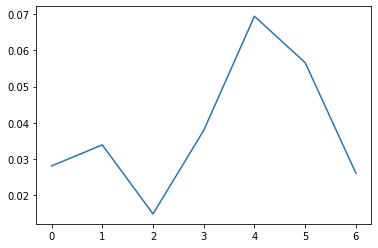

In [ ]:
value_at = 0

zero_avg_row0 = np.average(np.array(md[0:500,6:25:3]), axis=0)
zero_avg_row1 = np.average(np.array(md[0:500,27:46:3]), axis=0)

ind_avg_row0 = md[value_at,6:25:3]
ind_avg_row1 = md[value_at,27:46:3]


delta_row0 = abs(np.subtract(zero_avg_row0, ind_avg_row0))
delta_row1 = abs(np.subtract(zero_avg_row1, ind_avg_row1))

diff = abs(np.subtract(delta_row0, delta_row1))
plt.plot(diff)
print('Max indent measured difference row0&row1:', round(np.amax(diff),4), 'mm')

###3D Point Conversion

In [ ]:
def format_points_3d(point_array):
  structure = []
  for frame in point_array:
    grouped = []

    for i in range(int((frame.size - 5) / 3)): 
      index = (i * 3) + 5
      point_set = np.array([frame[index], frame[index + 1], frame[index + 2]])
      grouped.append(point_set)


    structure.append(np.array(grouped).reshape(7,7,3))
  return np.array(structure)

In [ ]:
points = format_points_3d(md)

In [ ]:
value_at = 160386
x = np.concatenate(points[value_at,:,:,0]) #x
y = np.concatenate(points[value_at,:,:,1]) #y
z = np.concatenate(points[value_at,:,:,2]) #z

value_at = 200923
x1 = np.concatenate(points[value_at,:,:,0]) #x
y1 = np.concatenate(points[value_at,:,:,1]) #y
z1 = np.concatenate(points[value_at,:,:,2]) #z


fig = go.Figure(
    data=[
          go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color='red')),
          go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', marker=dict(size=5, color='blue'))
        ]
)


camera = dict(
  eye=dict(x=1., y=0., z=0)
)

scene = dict(
  xaxis = dict(nticks=4, range=[-5,32],),
  yaxis = dict(nticks=4, range=[-5,100],),
  zaxis = dict(nticks=4, range=[-5,100],)
)

fig.update_layout(scene_camera=camera, scene = scene, width = 700)


#
fig.layout.scene.camera.projection.type = "orthographic"

fig.show()



### Transformation of Points

In [ ]:
value_at = 160386

origin = points[value_at,0,6,:]

v_a = points[value_at,0,0,:] - origin
v_b = points[value_at,6,6,:] - origin
v_c = np.cross(v_a, v_b)

v_b= np.cross(v_c,v_a)

c_x = [1,0,0]
c_y = [0,1,0]
c_z = [0,0,1]



V = np.array((v_a, v_b, v_c))

#normalize V
for i in range(V.shape[0]):
  V[i] = V[i]/np.linalg.norm(V[i])


C = np.array((c_x, c_y, c_z))

m = np.linalg.solve(V,C).T 

print(m)



[[-0.0433699   0.99905858  0.00100684]
 [ 0.00434667 -0.00081909  0.99999022]
 [ 0.99904963  0.04337386 -0.00430705]]


In [ ]:
value_at = 160386
x = np.concatenate(points[value_at,:,:,0]) #x
y = np.concatenate(points[value_at,:,:,1]) #y
z = np.concatenate(points[value_at,:,:,2]) #z

fig = go.Figure(
    data=[
          go.Scatter3d(x=origin[0]+ V[:,0], y=origin[1]+V[:,1], z=origin[1]+V[:,2]), #marker coord
          go.Scatter3d(x=[origin[0]], y=[origin[1]], z=[origin[2]], mode = 'markers'), #marker origin
          go.Scatter3d(x = [0,0,0,1], y = [0,1,0,0], z = [0,0,1,0], mode = 'markers'), #normal coord
          go.Scatter3d(x=x, y=y, z=z, mode='markers')#markers

          
        ]
)

scene = dict(
  xaxis = dict(range=[-2,2],),
  yaxis = dict(range=[-2,2],),
  zaxis = dict(range=[-2,2],)
)

fig.update_layout( scene = scene, width = 700)
fig.layout.scene.camera.projection.type = "orthographic"


fig.show()

In [ ]:
M = np.identity(4)

M[:3,:3] = m



print((M.T@[1,0,0,1])[:3] + origin)



[-1.4130199   1.01097258  0.02169284]


In [ ]:
T = np.identity(4)
T[:3,-1] = - origin

p = np.ones(4)

p[:3] = points[0,6,0,:] #x



print(M@T@p)

[113.45769172 110.4104527    0.20466125   1.        ]


In [ ]:
t_points = np.ones((points.shape[0],7,7,4))
t_points[:,:,:,:3] = points

for i in range(t_points.shape[0]):
  for j in range(t_points.shape[1]):
    for k in range(t_points.shape[2]):
      t_points[i,j,k] = M@T@t_points[i,j,k]
    

In [ ]:
value_at = 160386
x = np.concatenate(t_points[value_at,:,:,0]) #x
y = np.concatenate(t_points[value_at,:,:,1]) #y
z = np.concatenate(t_points[value_at,:,:,2]) #z

value_at = 124345
x1 = np.concatenate(t_points[value_at,:,:,0]) #x
y1 = np.concatenate(t_points[value_at,:,:,1]) #y
z1 = np.concatenate(t_points[value_at,:,:,2]) #z



fig = go.Figure(
    data=[
          go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color='red')),
          go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', marker=dict(size=5, color='blue'))#,

        ]
)


camera = dict(
  eye=dict(x=0., y=0., z=1.0)
)

scene = dict(
  xaxis = dict(nticks=4, range=[-5,100],),
  yaxis = dict(nticks=4, range=[-5,100],),
  zaxis = dict(nticks=4, range=[-5,32],)
)

fig.update_layout(scene = scene)


#
#fig.layout.scene.camera.projection.type = "orthographic"


fig.show()

###2D Delta

In [ ]:
d_x = np.zeros((7,7))
d_y = np.zeros((7,7))

for i in range(7):
  for j in range(7):
    d_x[i,j] = t_points[794,i,j,0] -  t_points[0,i,j,0]
    d_y[i,j] = t_points[794,i,j,1] -  t_points[0,i,j,1]

print(np.round(np.sqrt(d_x**2 + d_y**2), 3))


[[0.032 0.08  0.021 0.028 0.048 0.074 0.076]
 [0.071 0.108 0.082 0.063 0.185 0.279 0.14 ]
 [0.055 0.097 0.11  0.338 0.808 0.435 0.162]
 [0.053 0.079 0.247 0.49  0.495 0.27  0.075]
 [0.048 0.034 0.097 0.229 0.249 0.122 0.08 ]
 [0.043 0.15  0.07  0.18  0.142 0.13  0.073]
 [0.016 0.044 0.092 0.105 0.132 0.058 0.021]]


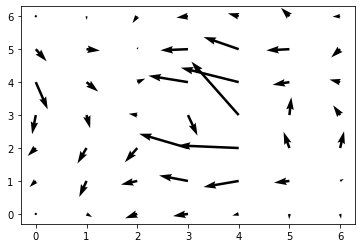

In [ ]:
x,y = np.arange(0, 7, 1), np.arange(0, 7, 1)
u,v = t_points[16035,:,:,0] - t_points[0,:,:,0], t_points[16035,:,:,1] - t_points[0,:,:,1]
#u,v = np.meshgrid(x,y)

fig, ax = plt.subplots()
q = ax.quiver(x, y, u, v)

fig.figure
plt.show()



###Animation of frames

In [ ]:
import plotly.graph_objects as go


t_points = np.load('/content/drive/MyDrive/mil/data/analytics/data.npy')
peaks = np.load('/content/drive/MyDrive/mil/data/analytics/peaks.npy')

x,y,z = [],[],[]
for i in range(t_points.shape[0]):
  x.append(np.concatenate(t_points[i,:,:,0]))
  y.append(np.concatenate(t_points[i,:,:,1]))
  z.append(np.concatenate(t_points[i,:,:,2]))

x, y, z = np.array(x), np.array(y), np.array(z)

# Create figure
fig = go.Figure(go.Scatter3d(x=[], y=[], z=[],
                             mode="markers",
                             marker=dict(color="red", size=4)
                             )
                )

    
# Frames
frames = [go.Frame(data= [go.Scatter3d(x=x[k],
                                       y=y[k],
                                       z=z[k]
                                       )
                          ],
                   traces= [0],
                   name=f'frame{k}'      
                  )for k  in  peaks
          ]

fig.update(frames=frames)




def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
            }


sliders = [
    {"pad": {"b": 10, "t": 60},
     "len": 0.9,
     "x": 0.1,
     "y": 0,
     
     "steps": [
                 {"args": [[f.name], frame_args(0)],
                  "label": str(k),
                  "method": "animate",
                  } for k, f in enumerate(fig.frames)
              ]
     }
        ]

fig.update_layout(

    updatemenus = [{"buttons":[
                    {
                        "args": [None, frame_args(50)],
                        "label": "Play", 
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "Pause", 
                        "method": "animate",
                  }],
                    
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
    )


fig.update_layout(scene = dict(
    xaxis = dict(nticks=4, range=[-5,100],),
    yaxis = dict(nticks=4, range=[-5,100],),
    zaxis = dict(nticks=4, range=[-5,32],)
                               )
                  )

fig.update_layout(sliders=sliders)
fig.show()

In [ ]:
peak_number = 346
print('Frame with peak:', peaks[loc][peak_number])

Frame with peak: 124345


###Surface Plot

In [ ]:
print('Location of peaks:\n', peaks[loc])

In [ ]:
value_at = 124345
x = t_points[value_at,0,:,0]
y = t_points[value_at,:,0,1]
z = t_points[value_at,:,:,2]

fig = go.Figure(data=[
    go.Surface(
        x=x, y=y, z=z,
        #contours=dict(start=0, end=20, size=2,),
        #contours_coloring='lines', 
        #colorscale='electric',

    )])

scene = dict(
  xaxis = dict(nticks=4, range=[-5,100],),
  yaxis = dict(nticks=4, range=[-5,100],),
  zaxis = dict(nticks=4, range=[-5,100],)
)

fig.update_layout(scene=scene, height = 600)
fig.show()

###Contour

In [ ]:
value_at = 124345
x = t_points[value_at,0,:,0]
y = t_points[value_at,:,0,1]
z = t_points[value_at,:,:,2]

fig = go.Figure(data=[
    go.Contour(
        x=x, y=y, z=z,
        contours=dict(start=0, end=20, size=2,),
        contours_coloring='lines', 
        line_width=1.5,
        #colorscale='electric',

    )])



fig.update_layout(width=600, height=600,)
fig.show()

#Export


In [ ]:
from numpy import save

In [ ]:
rotated_tp = rotate_points(t_points[:,:,:,:3])


In [ ]:
save('data.npz', rotated_tp)

In [ ]:
control = md[:,2:5]
t_c = np.ones((control.shape[0], 4))
t_c[:,:3] = control

In [ ]:
for i in range(t_c.shape[0]):
  t_c[i] = M@T@t_c[i]


transposed = t_c[:,:3]
save('control.npy', transposed)


#Import


In [ ]:
l = np.load('/content/drive/MyDrive/mil/data/analytics/data.npy')
test = l[124345,:,:,:]


In [ ]:
def rotate_points(input_array):
  flip = np.ones((input_array.shape[0],7,7,3))
  for k in range(input_array.shape[0]):
    for i in range(7):
      for j in range(7):
        flip[k,i,j,:] = input_array[k,j,i,:]
        flip[k,j,i,:] = input_array[k,i,j,:]
  return flip[:,::-1,:]



In [ ]:


print(rotate_points(l)[124345,0,0])


[ 0.02679843 -0.0431176   0.83230967]
